In [1]:
import os
from pathlib import Path
import json
import time

import pandas as pd
import matplotlib.pyplot as plt

os.chdir("..")
print("CWD:", os.getcwd())

BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "data"
INDEX_PATH = DATA_DIR / "dataset_index.csv"

META_DIR = BASE_DIR / "metadata" / "final_profiles"
RESULTS_DIR = BASE_DIR / "results" / "evaluation"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

index_df = pd.read_csv(INDEX_PATH)
index_df.head()


CWD: /home/jovyan


,dataset_id,category,name,nyc_url,csv_url,local_path,download_status,can_load_100_rows,num_cols_sample,num_rows,num_cols
0,f9bf-2cp4,Education,NaN,https://data.cityofnewyork.us/resource/f9bf-2cp4,https://data.cityofnewyork.us/api/views/f9bf-2...,data/raw/education/f9bf-2cp4.csv,ok,True,6,478.0,6.0
1,x3bb-kg5j,Education,NaN,https://data.cityofnewyork.us/resource/x3bb-kg5j,https://data.cityofnewyork.us/api/views/x3bb-k...,data/raw/education/x3bb-kg5j.csv,ok,True,6,277153.0,6.0
2,zt9s-n5aj,Education,NaN,https://data.cityofnewyork.us/resource/zt9s-n5aj,https://data.cityofnewyork.us/api/views/zt9s-n...,data/raw/education/zt9s-n5aj.csv,ok,True,6,460.0,6.0
3,s3k6-pzi2,Education,NaN,https://data.cityofnewyork.us/resource/s3k6-pzi2,https://data.cityofnewyork.us/api/views/s3k6-p...,data/raw/education/s3k6-pzi2.csv,ok,True,462,440.0,462.0
4,pd5h-92mc,Education,NaN,https://data.cityofnewyork.us/resource/pd5h-92mc,https://data.cityofnewyork.us/api/views/pd5h-9...,data/raw/education/pd5h-92mc.csv,ok,True,14,64.0,14.0


In [2]:
def build_deep_profile_prompt(metadata_dict):
    name = metadata_dict.get("name")
    category = metadata_dict.get("category")
    schema = metadata_dict.get("schema") or {}
    num_rows = schema.get("num_rows")
    num_cols = schema.get("num_cols")

    numeric_profile = metadata_dict.get("numeric_profile") or {}
    categorical_profile = metadata_dict.get("categorical_profile") or {}
    feature_groups = metadata_dict.get("feature_groups") or {}

    parts = []
    parts.append(f"Dataset name: {name}")
    parts.append(f"Category: {category}")
    parts.append(f"Approximate schema: rows={num_rows}, columns={num_cols}")
    parts.append("")

    if numeric_profile:
        parts.append("Numeric fields summary:")
        for col, prof in numeric_profile.items():
            vals = []
            for key in ("count", "mean", "stddev", "min", "max"):
                v = prof.get(key)
                if v is not None:
                    vals.append(f"{key}={v}")
            parts.append(f"- {col}: " + ", ".join(vals))
        parts.append("")

    if categorical_profile:
        parts.append("Categorical fields (top categories):")
        for col, prof in categorical_profile.items():
            top_vals = prof.get("top_values") or []
            top_slice = top_vals[:5]
            pretty = []
            for t in top_slice:
                v = t.get("value")
                p = t.get("percent")
                if p is not None:
                    pretty.append(f"{v} ({p:.1%})")
                else:
                    pretty.append(str(v))
            parts.append(f"- {col}: " + ", ".join(pretty))
        parts.append("")

    if feature_groups:
        parts.append("Feature groups:")
        for prefix, cols in feature_groups.items():
            if len(cols) > 1:
                parts.append(f"- {prefix}: {', '.join(cols)}")
        parts.append("")

    parts.append(
        "Using the structured summary above, write a concise but information-rich natural language "
        "description of this dataset, explaining what it contains, how it can be used, and any notable "
        "patterns, caveats, or biases."
    )

    return "\n".join(parts)


In [3]:
meta_files = sorted(META_DIR.glob("*.json"))
len(meta_files)


40

In [4]:
subset_size = min(10, len(meta_files))
subset_meta_files = meta_files[:subset_size]
subset_meta_files


[PosixPath('/home/jovyan/metadata/final_profiles/23z9-6uk9.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/3khw-qi8f.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/4e2n-s75z.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/6iwb-7euj.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/6z8x-wfk4.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/7z8d-msnt.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/7zb8-7bpk.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/9nt8-h7nd.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/9rz4-mjek.json'),
 PosixPath('/home/jovyan/metadata/final_profiles/c7ru-d68s.json')]

In [5]:
def simple_baseline_description(dataset_id, local_path, nrows=5):
    import pandas as pd

    try:
        df = pd.read_csv(local_path, nrows=nrows)
    except Exception as e:
        return f"Baseline description for {dataset_id} could not load sample rows: {e}"

    cols = list(df.columns)
    preview = df.head(2).to_dict(orient="records")

    desc = (
        f"This NYC Open Data dataset with ID {dataset_id} has columns: {', '.join(cols)}. "
        f"The sample rows suggest it includes tabular information about NYC related to its category. "
        f"Here are a couple of example records (truncated): {preview}"
    )
    return desc


baseline_descs = []
baseline_start = time.time()

for meta_path in subset_meta_files:
    with meta_path.open() as f:
        meta = json.load(f)

    dataset_id = meta["dataset_id"]
    idx_row = index_df.loc[index_df["dataset_id"] == dataset_id].iloc[0]
    local_path = idx_row["local_path"]
    full_path = str(BASE_DIR / local_path)

    baseline_description = simple_baseline_description(dataset_id, full_path)

    baseline_descs.append(
        {
            "dataset_id": dataset_id,
            "baseline_description": baseline_description,
        }
    )

baseline_total_time = time.time() - baseline_start

with (RESULTS_DIR / "baseline_descriptions.json").open("w") as f:
    json.dump(baseline_descs, f, indent=2)

baseline_total_time, len(baseline_descs)


(0.1215972900390625, 10)

In [6]:
def simulate_llm_response(prompt: str, max_chars=1500):
    text = prompt.replace("\n", " ")
    if len(text) > max_chars:
        text = text[:max_chars] + "..."
    return "DEEP PROFILED DESCRIPTION (SIMULATED): " + text


deep_profile_descs = []
deep_start = time.time()

for meta_path in subset_meta_files:
    with meta_path.open() as f:
        meta = json.load(f)

    dataset_id = meta["dataset_id"]
    prompt = build_deep_profile_prompt(meta)

    deep_description = simulate_llm_response(prompt)

    deep_profile_descs.append(
        {
            "dataset_id": dataset_id,
            "deep_description": deep_description,
        }
    )

deep_total_time = time.time() - deep_start

with (RESULTS_DIR / "deep_descriptions.json").open("w") as f:
    json.dump(deep_profile_descs, f, indent=2)

deep_total_time, len(deep_profile_descs)


(0.0037467479705810547, 10)

In [7]:
with (RESULTS_DIR / "baseline_descriptions.json").open() as f:
    baseline_descs = json.load(f)

with (RESULTS_DIR / "deep_descriptions.json").open() as f:
    deep_descs = json.load(f)

queries = [
    "datasets about student demographics",
    "datasets about school performance",
    "datasets about NYC government finances",
]

relevance = {
    "datasets about student demographics": [
        # fill with dataset_ids you judge relevant, e.g. "s52a-8aq6", "c7ru-d68s", ...
    ],
    "datasets about school performance": [
        # e.g. SAT, AP, high school directory, etc.
    ],
    "datasets about NYC government finances": [
        # e.g. tax, property tax, contract awards, etc.
    ],
}


In [8]:
def keyword_score(text: str, query: str) -> int:
    text_l = text.lower()
    words = query.lower().split()
    score = 0
    for w in words:
        if w in text_l:
            score += 1
    return score


def rank_datasets(descs, text_key, query, top_k=None):
    scored = []
    for d in descs:
        text = d[text_key]
        score = keyword_score(text, query)
        if score > 0:
            scored.append((d["dataset_id"], score))
    scored.sort(key=lambda x: x[1], reverse=True)
    if top_k is not None:
        scored = scored[:top_k]
    return scored


In [9]:
results = []

for q in queries:
    relevant_ids = relevance.get(q, [])
    baseline_ranked = rank_datasets(baseline_descs, "baseline_description", q, top_k=None)
    deep_ranked = rank_datasets(deep_descs, "deep_description", q, top_k=None)

    baseline_hits = [d for d, s in baseline_ranked]
    deep_hits = [d for d, s in deep_ranked]

    if relevant_ids:
        baseline_recall = len(set(baseline_hits) & set(relevant_ids)) / len(relevant_ids)
        deep_recall = len(set(deep_hits) & set(relevant_ids)) / len(relevant_ids)
    else:
        baseline_recall = None
        deep_recall = None

    results.append(
        {
            "query": q,
            "baseline_hits": baseline_hits,
            "deep_hits": deep_hits,
            "baseline_recall": baseline_recall,
            "deep_recall": deep_recall,
        }
    )

find_df = pd.DataFrame(results)
find_df.to_csv(RESULTS_DIR / "findability_results.csv", index=False)
find_df


,query,baseline_hits,deep_hits,baseline_recall,deep_recall
0,datasets about student demographics,"[23z9-6uk9, c7ru-d68s, 3khw-qi8f, 4e2n-s75z, 6...",[],None,None
1,datasets about school performance,"[23z9-6uk9, 4e2n-s75z, 6iwb-7euj, c7ru-d68s, 3...",[],None,None
2,datasets about NYC government finances,"[23z9-6uk9, 3khw-qi8f, 4e2n-s75z, 6iwb-7euj, 6...","[3khw-qi8f, 4e2n-s75z, 6z8x-wfk4, 7zb8-7bpk, 9...",None,None


In [10]:
numeric_times_path = BASE_DIR / "profiles" / "numeric_profiling_times.csv"
categorical_times_path = BASE_DIR / "profiles" / "categorical_profiling_times.csv"

numeric_times = pd.read_csv(numeric_times_path) if numeric_times_path.exists() else None
categorical_times = pd.read_csv(categorical_times_path) if categorical_times_path.exists() else None

runtime_records = []

runtime_records.append(
    {
        "task": "baseline_descriptions",
        "total_seconds": baseline_total_time,
        "avg_seconds_per_dataset": baseline_total_time / len(baseline_descs) if baseline_descs else None,
    }
)

runtime_records.append(
    {
        "task": "deep_profile_descriptions",
        "total_seconds": deep_total_time,
        "avg_seconds_per_dataset": deep_total_time / len(deep_profile_descs) if deep_profile_descs else None,
    }
)

if numeric_times is not None and not numeric_times.empty:
    runtime_records.append(
        {
            "task": "numeric_profiling",
            "total_seconds": numeric_times["seconds"].sum(),
            "avg_seconds_per_dataset": numeric_times["seconds"].mean(),
        }
    )

if categorical_times is not None and not categorical_times.empty:
    runtime_records.append(
        {
            "task": "categorical_profiling",
            "total_seconds": categorical_times["seconds"].sum(),
            "avg_seconds_per_dataset": categorical_times["seconds"].mean(),
        }
    )

runtime_df = pd.DataFrame(runtime_records)
runtime_df.to_csv(RESULTS_DIR / "runtime_summary.csv", index=False)
runtime_df


,task,total_seconds,avg_seconds_per_dataset
0,baseline_descriptions,0.121597,0.012160
1,deep_profile_descriptions,0.003747,0.000375
2,numeric_profiling,275.878402,13.793920


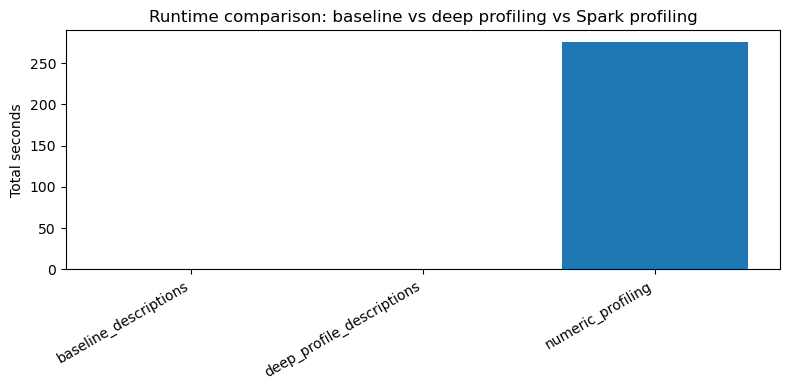

In [11]:
plt.figure(figsize=(8, 4))
plt.bar(runtime_df["task"], runtime_df["total_seconds"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Total seconds")
plt.title("Runtime comparison: baseline vs deep profiling vs Spark profiling")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "runtime_bar_chart.png", dpi=150)
plt.show()
